# From optical flow to temperature

### Initial imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
import keras.backend as K

### Loading images and coordinates

In [2]:
data_path = "data/3ball/"

X1 = []
for i in tqdm(glob(data_path + "Input/image1_*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    X1.append(im)
X1 = np.array(X1, dtype="float32") / 255

X2 = []
for i in tqdm(glob(data_path + "Input/image2_*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    X2.append(im)
X2 = np.array(X2, dtype="float32") / 255

coordinates = np.loadtxt(data_path + 'coordinates.csv', delimiter=',')

100%|██████████| 10000/10000 [00:02<00:00, 4317.35it/s]


### Generation of synthetic optical flow

From the coordinates data we generate the optical flows and compute the temperature of the systems.

In [3]:
# Dataset dependant parameters
num_systems = 10000
num_balls = 3
pix = 32

# We divide the second part (velocity vectors) by 4 to have (or close to have) them between -1 and 1
coordinates = np.concatenate((coordinates[:, :2*num_balls], coordinates[:, -2*num_balls:] / 4), axis=1)

# Initialization of the needed data
optical_flow = np.zeros((num_systems, pix, pix, 2))
temperature = np.zeros((num_systems))

# For each system we compute the optical flow and temperature
for i in range(num_systems):
    for j in range(num_balls):
        # Store optical flow information
        optical_flow[i, coordinates[i, 2*j].astype(int), coordinates[i, 2*j+1].astype(int)] = coordinates[i, 2*num_balls + 2*j], coordinates[i, 2*num_balls + 2*j+1]
        # Compute temperature value
        temperature[i] += np.sqrt(np.sum(np.square(coordinates[i, 2*num_balls + 2*j : 2*num_balls + 2*(j+1)])))

Here we print (from left to right) the two frames of the sample, a 3rd image with both balls (black for first frame and purple for second frame) to see the movement, and a 4th image with the synthetic optical flow.

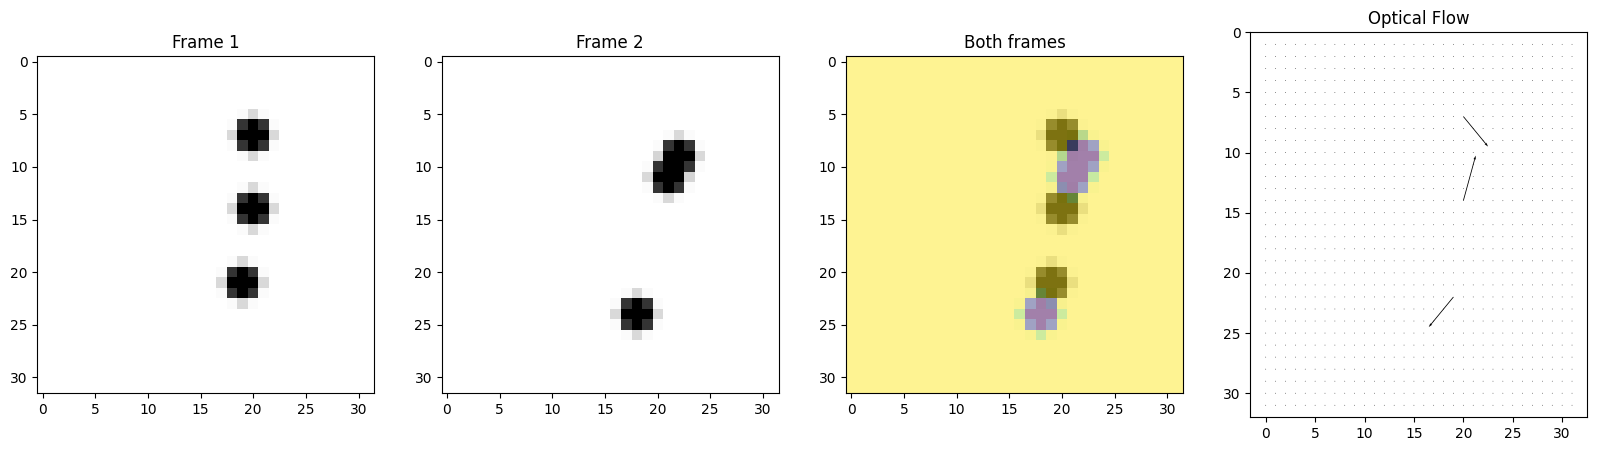

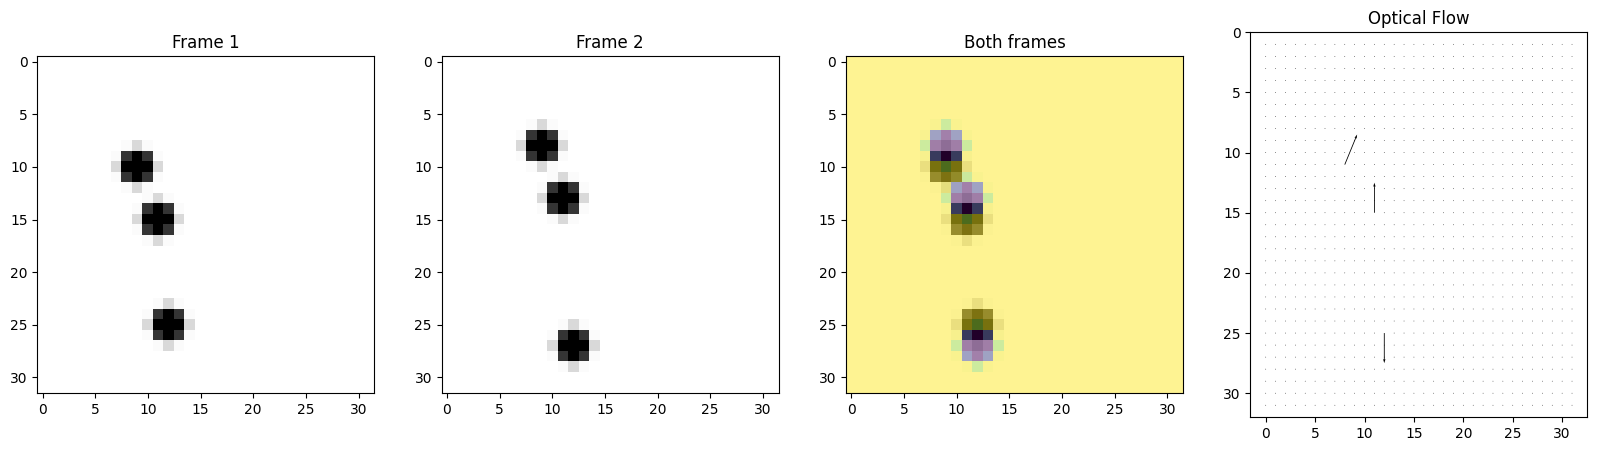

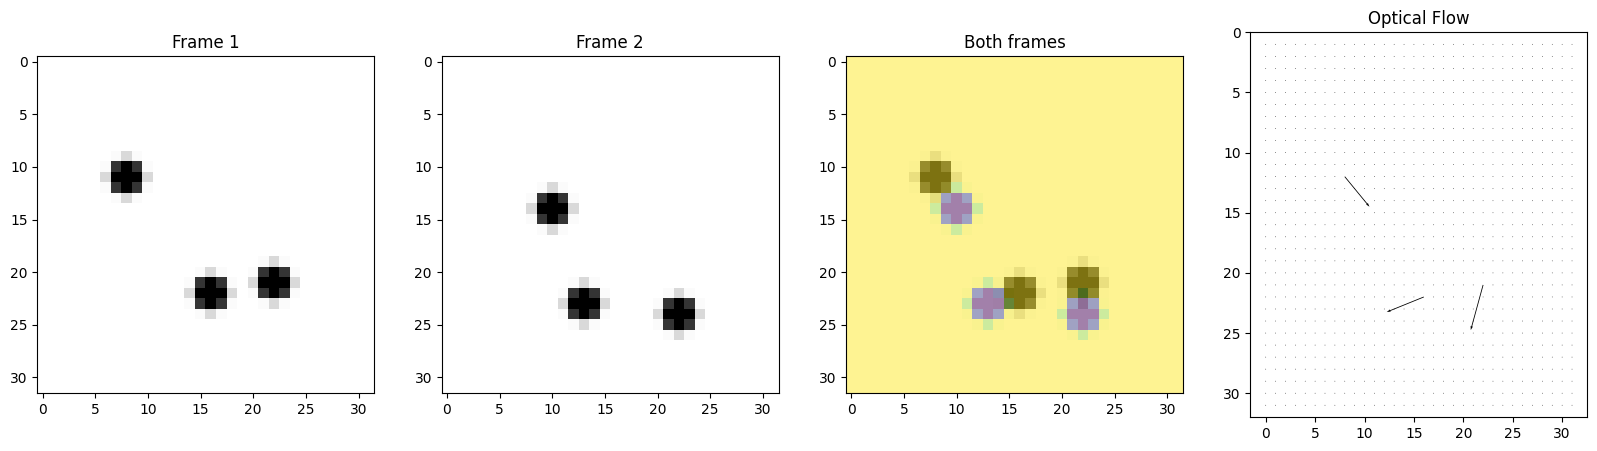

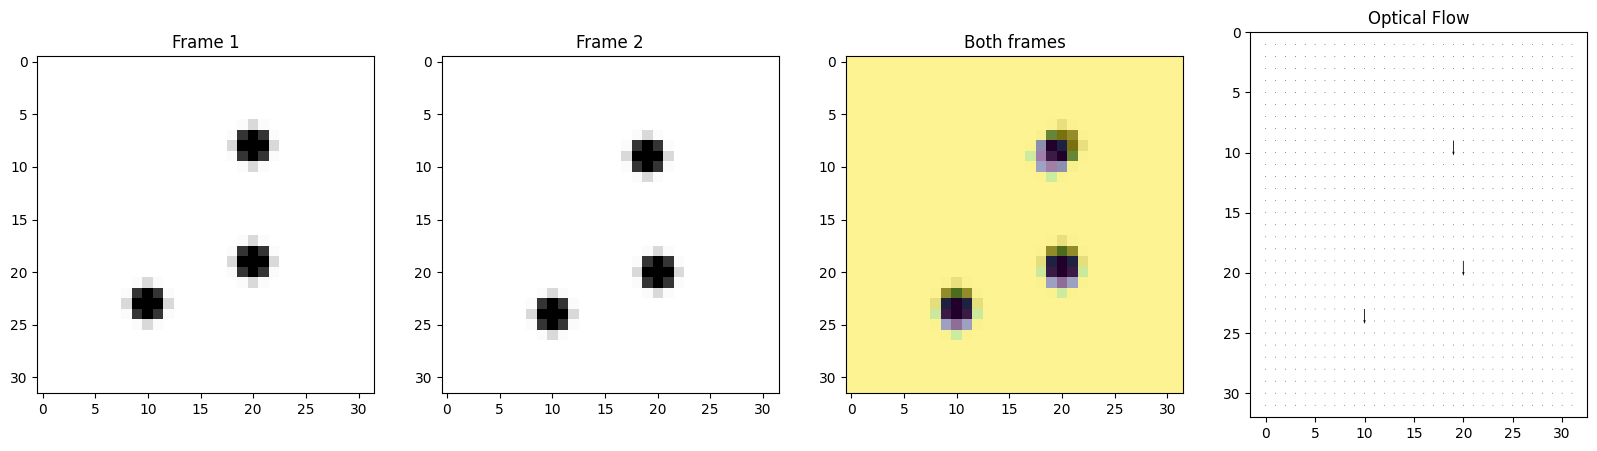

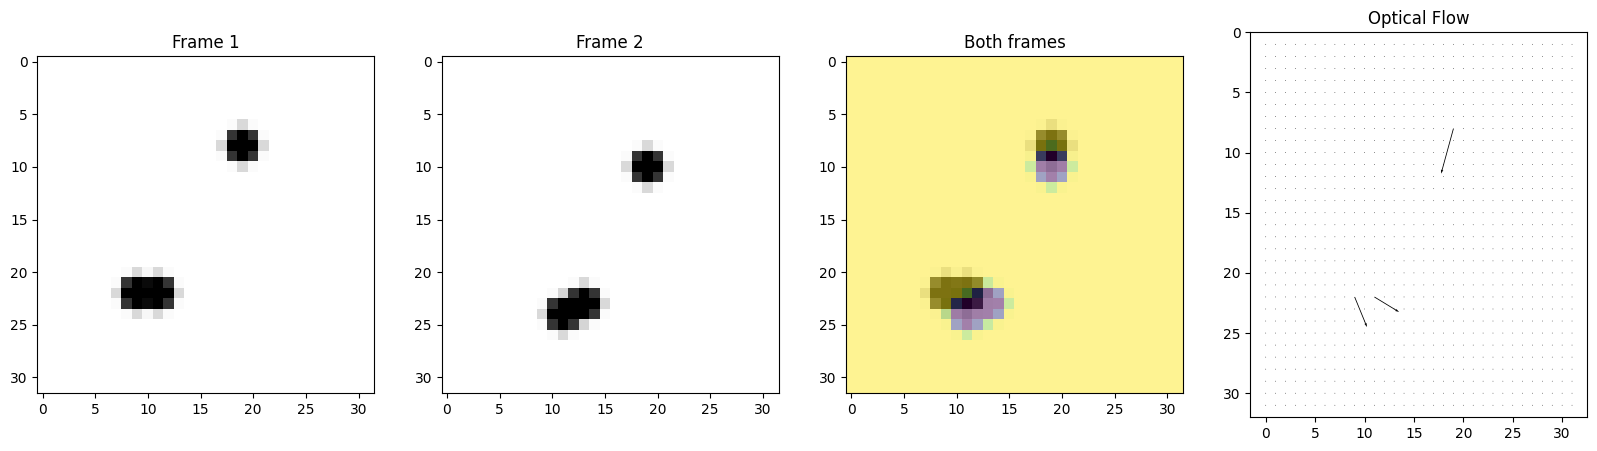

In [4]:
for i in range(5):
    plt.figure(figsize=(20, 5))

    plt.subplot(141)
    plt.title('Frame 1')
    plt.imshow(X1[i], cmap='gray')

    plt.subplot(142)
    plt.title('Frame 2')
    plt.imshow(X2[i], cmap='gray')

    plt.subplot(143)
    plt.title('Both frames')
    plt.imshow(X1[i], cmap='gray')
    plt.imshow(X2[i], alpha=0.5)

    plt.subplot(144)
    plt.ylim(32, 0)
    plt.title('Optical Flow')
    plt.quiver(optical_flow[i, ::1, ::1, 0], optical_flow[i, ::1, ::1, 1],
            angles='xy',            # use 'xy' angles for consistent arrow orientation
            scale_units='xy',       # use 'xy' scale units for consistent arrow length
            scale=0.2)

    plt.show()

plt.close()

### Model definition and training

In [5]:
def model(input_shape):
   inputs = Input(shape=input_shape)

   x = Flatten()(inputs)

   x = Dense(128, activation="relu")(x)
   x = Dense(6)(x)
   outputs = Dense(1)(x)
    
   model = Model(inputs=inputs, outputs=outputs)
   return model

model = model((pix, pix, 2))

model.summary()

# Free up RAM in case the model definition cells were run multiple times
K.clear_session()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 263,053
Trainable params: 263,053
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Train-val-test split (80-10-10)
x_train, x_test, y_train, y_test = train_test_split(optical_flow, temperature, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae')

# Fit the model
model.fit(x_train, y_train,
          epochs=250,
          batch_size=16,
          shuffle=True,
          validation_data=(x_val, y_val),
          callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta = 0.0001)])

Epoch 1/250
500/500 [==============================] - 6s 10ms/step - loss: 0.4378 - val_loss: 0.2801
Epoch 2/250
500/500 [==============================] - 4s 8ms/step - loss: 0.1782 - val_loss: 0.1701
Epoch 3/250
500/500 [==============================] - 4s 8ms/step - loss: 0.1448 - val_loss: 0.1648
Epoch 4/250
500/500 [==============================] - 3s 5ms/step - loss: 0.1254 - val_loss: 0.1578
Epoch 5/250
500/500 [==============================] - 4s 7ms/step - loss: 0.1128 - val_loss: 0.1671
Epoch 6/250
500/500 [==============================] - 5s 9ms/step - loss: 0.1056 - val_loss: 0.1799
Epoch 7/250
500/500 [==============================] - 3s 6ms/step - loss: 0.0992 - val_loss: 0.1600
Epoch 8/250
500/500 [==============================] - 2s 5ms/step - loss: 0.0930 - val_loss: 0.1618
Epoch 9/250
500/500 [==============================] - 4s 8ms/step - loss: 0.0902 - val_loss: 0.1736
Epoch 10/250
500/500 [==============================] - 3s 5ms/step - loss: 0.0857 - val_l

### Model results

In [7]:
predictions = model.predict(x_test)

for i in range(5):
    print(str(i) + '\nPrediction: ' + str(predictions[i]) + '\nActual temperature: ' + str(y_test[i]))

32/32 [==============================] - 0s 4ms/step
0
Prediction: [1.7328703]
Actual temperature: 1.868033988749895
1
Prediction: [1.5171423]
Actual temperature: 1.618033988749895
2
Prediction: [1.0078019]
Actual temperature: 1.2071067811865475
3
Prediction: [1.6413714]
Actual temperature: 1.5590169943749475
4
Prediction: [0.93420327]
Actual temperature: 0.8535533905932737
